In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

KeyboardInterrupt: ignored

In [ ]:
import numpy as np
import pandas as pd
import regex
import os
import urllib
from bs4 import BeautifulSoup
from wordcloud import WordCloud
import gensim
from gensim.utils import lemmatize
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy #python3 -m spacy download it_core_news_sm
# import pyLDAvis
# import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
from spacy.lang.it.stop_words import STOP_WORDS as ita

In [ ]:
import os       #importing os to set environment variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

openjdk version "11.0.7" 2020-04-14
OpenJDK Runtime Environment (build 11.0.7+10-post-Ubuntu-2ubuntu218.04)
OpenJDK 64-Bit Server VM (build 11.0.7+10-post-Ubuntu-2ubuntu218.04, mixed mode, sharing)


In [ ]:

!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

In [ ]:
#find . -name '.DS_Store' -type f -delete
directory = '/Users/pietroaluffi/Downloads/SOLE24ORE/'
d = []
for filename in os.listdir(directory):
#     print('----------',filename)
    file = open(directory+filename, "r").read()
    soup = BeautifulSoup(file)
    d.append(
        {
            'Date': ", ".join([element.text.strip() for element in soup.find_all(class_='meta-part time')]),
            'Title': ", ".join([element.text.strip() for element in soup.find_all(class_='hlink hlink--page-title')]),
            'Article': ", ".join([element.text.strip() for element in soup.find_all(class_='atext')])
            
        }
    )
df = pd.DataFrame(d)

In [ ]:
len(df)
df = pd.DataFrame(d)
for c in range(len(df)):
    li = list(df.Date[c].split(" "))
    for n, i in enumerate(li):
        if i == 'gennaio':
            li[n] = 'January'
        if i == 'febbraio':
            li[n] = 'February'
        if i == 'marzo':
            li[n] = 'March'
        if i == 'aprile':
            li[n] = 'April'
        if i == 'maggio':
            li[n] = 'May'
    df.Date[c] = ", ".join(li)
                
                
# #df = pd.DataFrame(d)
# df['Date'] =pd.to_datetime(df.Date)
# df =df.dropna().set_index('Date').sort_index()
# texts = df.Article.values.tolist()

3401

In [ ]:
df.to_csv('data_processed_ITA_MAY_26.csv')

In [ ]:
#regular expression: formatting text
def formatting(texts):
    texts = [regex.sub('\s+', ' ', text) for text in texts] #remove new lines
    texts = [regex.sub("\"", "", text) for text in texts] #remove quotations
    texts = [regex.sub("\'", "", text) for text in texts] #remove quotations
    texts = [regex.sub("\(", "", text) for text in texts] #remove parentesis
    texts = [regex.sub("\)", "", text) for text in texts] #remove parentesis
    return texts
formatted_text = formatting(texts)
formatted_text[0]

In [ ]:
stop_words = list(ita)
url = "https://countwordsfree.com/stopwords/italian/txt"
file = urllib.request.urlopen(url)
stop_ext = [line.decode("utf-8").strip() for line in file]
stop_words = stop_words + stop_ext
lemma = spacy.load('it')
def token(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence),deacc=True)) 

def bigram_trigram(texts):
    bigram = gensim.models.Phrases(formatted_text)
    trigram = gensim.models.Phrases(bigram[formatted_text])
    bigram_ = gensim.models.phrases.Phraser(bigram)
    trigram_ = gensim.models.phrases.Phraser(trigram)
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts] 
    bi = [bigram_[text] for text in texts]
    tri = [trigram_[bigram_[b]] for b in bi]
    return tri
def processing(texts, stop_words=stop_words):
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    output = []
    for text in texts:
        doc = lemma(" ".join(text)) 
        output.append([token.lemma_ for token in doc])
    # remove stopwords once more after lemmatization
    output = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in output]
    return output

tokens = list(token(formatted_text))
bi_tri = bigram_trigram(tokens)
final_data = processing(bi_tri)
df['ProcessedArticles'] = final_data

NameError: name 'formatted_text' is not defined

In [ ]:
df = pd.read_csv('/content/gdrive/My Drive/Research/Datasets/processed2010ITA.csv')
final_data = df['ProcessedArticles'].tolist()
final_data = [list(string.split(" ")) for string in final_data]

In [ ]:
#term document matrix
id2word = corpora.Dictionary(final_data)
corpus = [id2word.doc2bow(text) for text in final_data]

In [ ]:
# mallet_path = '/content/gdrive/My Drive/Research/mallet-2.0.8/bin/mallet' # update this path
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet' # you should NOT need to change this 
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


KeyboardInterrupt: ignored

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=final_data, start=2, limit=40, step=6)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda
# https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
# https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/


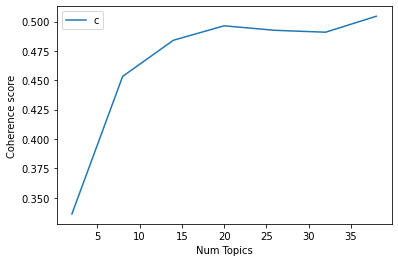

In [ ]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [2]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

NameError: ignored

In [1]:
import pprint
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
(optimal_model.topics(num_words=10))

NameError: ignored

In [ ]:
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=optimal_model):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=final_data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,17.0,0.1645,"'presidente',, 'confindustria',, 'temere',, 'c...","[['apprestare',, 'raggiungere',, 'costare',, '..."
1,1,19.0,0.3601,"'settore',, 'crisi',, 'rapportare',, 'crescita...","[['crisi',, 'scoraggiare',, 'imprenditori_stra..."
2,2,15.0,0.2388,"'fiat',, 'lavoratore',, 'contrattare',, 'sinda...","[['lanno',, 'azienda',, 'cassa_integrazione_st..."
3,3,7.0,0.2298,"'dollaro',, 'americano',, 'unito',, 'uso',, 'b...","[['borse_europee',, 'escludere',, 'listare',, ..."
4,4,15.0,0.4778,"'fiat',, 'lavoratore',, 'contrattare',, 'sinda...","[['contare',, 'rovescio',, 'consultazione',, '..."
5,5,1.0,0.1472,"'europeo',, 'litalia',, 'politico',, 'crescita...","[['crisi',, 'finito',, 'convinzione',, 'dellec..."
6,6,18.0,0.1306,"'politico',, 'economico',, 'potere',, 'venire'...","[['prendetevela',, 'texas',, 'whopper',, 'sand..."
7,7,0.0,0.1643,"'crisi',, 'debito',, 'mercato',, 'banca',, 'ri...","[['banchiere',, 'incontrare',, 'basilea',, 'se..."
8,8,15.0,0.4447,"'fiat',, 'lavoratore',, 'contrattare',, 'sinda...","[['vertenza',, 'fiat',, 'rimanere',, 'aprire',..."
9,9,15.0,0.2898,"'fiat',, 'lavoratore',, 'contrattare',, 'sinda...","[['presidente',, 'gara',, 'lamministratore_del..."


In [ ]:
df_dominant_topic = df_dominant_topic.set_index(df.index)

In [ ]:

df_dominant_topic = df_dominant_topic.assign(weekoftheyear=pd.PeriodIndex(df.index, freq='M'))


In [ ]:
df =df.dropna().set_index('Date').sort_index()


In [ ]:
df = df.assign(weekoftheyear=pd.PeriodIndex(df.index, freq='M'))


In [ ]:
df_dominant_topic.head(50)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,weekoftheyear
Date,,,,,,
2010-01-03,0,17.0,0.1645,"'presidente',, 'confindustria',, 'temere',, 'c...","[['apprestare',, 'raggiungere',, 'costare',, '...",2010-01
2010-01-04,1,19.0,0.3601,"'settore',, 'crisi',, 'rapportare',, 'crescita...","[['crisi',, 'scoraggiare',, 'imprenditori_stra...",2010-01
2010-01-04,2,15.0,0.2388,"'fiat',, 'lavoratore',, 'contrattare',, 'sinda...","[['lanno',, 'azienda',, 'cassa_integrazione_st...",2010-01
2010-01-04,3,7.0,0.2298,"'dollaro',, 'americano',, 'unito',, 'uso',, 'b...","[['borse_europee',, 'escludere',, 'listare',, ...",2010-01
2010-01-05,4,15.0,0.4778,"'fiat',, 'lavoratore',, 'contrattare',, 'sinda...","[['contare',, 'rovescio',, 'consultazione',, '...",2010-01
2010-01-06,5,1.0,0.1472,"'europeo',, 'litalia',, 'politico',, 'crescita...","[['crisi',, 'finito',, 'convinzione',, 'dellec...",2010-01
2010-01-08,6,18.0,0.1306,"'politico',, 'economico',, 'potere',, 'venire'...","[['prendetevela',, 'texas',, 'whopper',, 'sand...",2010-01
2010-01-10,7,0.0,0.1643,"'crisi',, 'debito',, 'mercato',, 'banca',, 'ri...","[['banchiere',, 'incontrare',, 'basilea',, 'se...",2010-01
2010-01-10,8,15.0,0.4447,"'fiat',, 'lavoratore',, 'contrattare',, 'sinda...","[['vertenza',, 'fiat',, 'rimanere',, 'aprire',...",2010-01


In [ ]:
dominant_topic = df_dominant_topic[['Dominant_Topic','weekoftheyear']].groupby('weekoftheyear').agg(lambda x:x.value_counts().index[0])
# dominant_topic['keywords'] = df_dominant_topic['Keywords']

In [ ]:
dominant_topic

,Dominant_Topic
weekoftheyear,
2010-01,15.0
2010-02,0.0
2010-04,10.0
2010-05,12.0
2010-06,16.0
2010-07,3.0
2010-08,7.0
2010-09,15.0
2010-10,16.0


In [ ]:
a = (optimal_model.show_topics(num_topics=20,formatted=False))

In [ ]:
((a[0][1])[0][0]).strip(",'")

'leggere'

In [ ]:
topic = [float(str((a[i][0]))+'.0') for i in range(20)]

In [ ]:
topic

[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0]

In [ ]:
len(a)

2

In [ ]:
a[2]

(2,
 [("'ce',", 0.02622898610068473),
  ("'volere',", 0.01949543893173184),
  ("'potere',", 0.018107782251643577),
  ("'dovere',", 0.016947610273209127),
  ("'problema',", 0.015810186764940056),
  ("'parlare',", 0.01519597807047476),
  ("'mettere',", 0.014013057621874929),
  ("'crisi',", 0.013444345867740395),
  ("'andare',", 0.01321686116608658),
  ("'pensare',", 0.013125867285425055)])

In [ ]:
words = [[((a[i][1])[j][0]).strip(",'") for j in range(5)] for i in range(20)]

In [ ]:
topics_df = pd.DataFrame([topic,words]).T
topics_df[0] = topic

In [ ]:
topics_df

,0,1
0,0.0,"[crisi, debito, mercato, banca, rischiare]"
1,1.0,"[europeo, litalia, politico, crescita, ue]"
2,2.0,"[ce, volere, potere, dovere, problema]"
3,3.0,"[leggere, entrare, previsto, manovrare, decret..."
4,4.0,"[regione, territorio, provincia, comune, milano]"
5,5.0,"[euro, prezzo, produrre, famiglia, italiano]"
6,6.0,"[auto, offrire, internet, mercato, lanciare]"
7,7.0,"[dollaro, americano, unito, uso, borsa]"
8,8.0,"[societa, italiano, italia, milano, presidente]"
9,9.0,"[impresa, credito, euro, banca, investimento]"


In [ ]:
end = pd.merge(dominant_topic,topics_df,how='left', left_on='Dominant_Topic', right_on=0).set_index(dominant_topic.index)

In [ ]:
pd.set_option("max_rows", None)

In [ ]:
end.to_csv('/content/gdrive/My Drive/Research/Datasets/topic_ita2010.csv')

In [ ]:
2010-2012_ITA.csv'